# DSML WS24/25 Exercise Sheet 10 - Code template

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from random import random

In [2]:
torch.set_num_threads(1)

In [3]:
class CustomDataset(Dataset):
    """Sample random subsequences of length T_seq from the provided dataset.
    The dataset is a torch tensor of shape (T, N)."""

    def __init__(self, data, T_seq):
        # T x N
        self.data = data
        self.T_seq = T_seq

    def __getitem__(self, t):
        # t is the index of the first time step
        # return a sequence of length T_seq
        # and the sequence shifted by one time step
        return (
            self.data[t : t + self.T_seq, :],
            self.data[t + 1 : t + self.T_seq + 1, :],
        )

    def __len__(self):
        # sets the allowed range of t
        return len(self.data) - self.T_seq - 1


class BatchSampler:
    """Samples sequences from the dataset and stacks them into batches."""

    def __init__(self, dataset, batch_size):
        self.B = batch_size
        self.dataset = dataset

    def __call__(self):
        # get indices
        batch = [self.dataset[i] for i in self.get_random_inital_conditions()]

        # stack the sequences into separate batches
        xs = torch.stack([x for x, _ in batch])
        ys = torch.stack([y for _, y in batch])

        # reshape to (T, B, N)
        return xs.permute(1, 0, 2), ys.permute(1, 0, 2)

    def get_random_inital_conditions(self):
        # return a list of initial conditions of size self.B
        return torch.randperm(len(self.dataset))[: self.B]

In [4]:
class CustomRNN(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(CustomRNN, self).__init__()
        self.M = latent_dim
        self.L = hidden_dim
        self.N = output_dim
        self.init_parameters()

    def init_parameters(self):
        r1 = 1.0 / (self.L**0.5)
        r2 = 1.0 / (self.M**0.5)
        self.W1 = nn.Parameter(nn.init.uniform_(torch.empty(self.M, self.L), -r1, r1))
        self.W2 = nn.Parameter(nn.init.uniform_(torch.empty(self.L, self.M), -r2, r2))
        self.A = nn.Parameter(nn.init.uniform_(torch.empty(self.M), a=0.5, b=0.9))
        self.h2 = nn.Parameter(nn.init.uniform_(torch.empty(self.L), -r1, r1))
        self.h1 = nn.Parameter(torch.zeros(self.M))

    def forward(self, z):
        """
        Given a vector of size (M,) or a matrix of size (B, M), compute one update of the latent state.

        Resulting shape: (M,) or (B, M)
        """
        return self.A * z + torch.relu(z @ self.W2.T + self.h2) @ self.W1.T + self.h1

    def __call__(self, z):
        return self.forward(z)

In [5]:
@torch.no_grad()
def generate_orbit(model, z0, T):
    """
    Generate an orbit of `model`, i.e. starting from initial condition vector `z0`, evolve the system for `T` time steps.

    Returns:
        orbit: torch.Tensor of shape (T, M)
    """
    M = len(z0)
    orbit = torch.empty(T, M)
    orbit[0, :] = z0
    for t in range(1, T):
        orbit[t, :] = model(orbit[t - 1, :])
    return orbit

## 1 Sparse Teacher Forcing for training RNNs

1.1 Complete the code to train the `CustomRNN` using sparse teacher forcing (STF). Everywhere you see
```python
... # your code here
```
you are supposed to implement the corresponding functionality that is explained at that location in the code.

In [6]:
def process_sequence_using_STF(model, x, t_forcing):
    """
    Performs an entire forward pass of the model given training sequence `x`
    using sparse teacher forcing with forcing interval `t_forcing`.
    """
    T, B, N = x.shape

    # manually initialize the hidden state of the model with zeros
    z0 = torch.zeros((B, model.M))  # your code here

    # force the read-out neurons of the rnn with the first data point in the sequence
    z0[:, :N] = x[0, :, :]  # your code here

    # will hold the entire predicted latent sequence
    Z = torch.zeros(T, B, model.M)

    # initial prediction based on first data point
    z = model(z0)
    Z[0, :, :] = z

    # remaining forward pass using STF
    for t in range(1, T):
        # intervals of the forcing signal
        if t % t_forcing == 0:
            # force the read-out neurons of the rnn
            z[:, :N] = x[t, :, :]  # your code here

        # update the (sparsely) forced latent state using the model
        z = model(z)  # your code here

        # store the predicted latent state
        Z[t, :, :] = z
    return Z

In [7]:
def train_RNN(rnn, dataloader, t_forcing, n_epochs, print_every, lr=5e-4):
    # gather parameters
    rnn_params = list(rnn.parameters())

    # the optimizer performing stochastic gradient descent
    optimizer = torch.optim.Adam(rnn_params, lr=lr)

    # the loss function
    criterion = nn.MSELoss()

    losses = []
    for epoch in range(n_epochs + 1):
        # get the data
        xs, ys = dataloader()

        # zero the gradients
        optimizer.zero_grad()

        # forward pass of the entire batch
        Z = process_sequence_using_STF(rnn, xs, t_forcing)

        # output layer simply returns the read-out neurons' outputs
        N = xs.shape[-1]
        y_pred = Z[:, :, :N]  # your code here

        # compute the loss
        loss = criterion(y_pred, ys)

        # backward pass, computes gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # store the loss
        losses.append(loss.item())

        # print the loss
        if epoch % print_every == 0:
            print("Epoch: {}, Loss: {}".format(epoch, loss.item()))

    return losses

### 2.2 Train the RNN and visually inspect the dynamics of the model
The hyperparameter settings should at least give you chaotic behavior, but in general you will get better models by increasing the number of epochs (if you have time and resources)

In [8]:
# set the hyper parameters
T_seq = 50
B = 16
epochs = 10000
learning_rate = 1e-3
t_forcing = 16
M = 10
L = 50

# load the data
X = torch.load("lorenz_data.pt")

# initialize the dataset
dataset = CustomDataset(X, T_seq)

# initialize the dataloader
dataloader = BatchSampler(dataset, B)
xs, ys = dataloader()

# initialize the model
rnn = CustomRNN(M, L, X.shape[-1])

# train the model
losses = train_RNN(
    rnn,
    dataloader,
    t_forcing=t_forcing,
    n_epochs=epochs,
    print_every=int(epochs / 10),
    lr=learning_rate,
)

# optionally save the trained model
# torch.save(rnn.state_dict(), "pretrained_model.pt")

/tmp/ipykernel_2676871/755594620.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load("lorenz_data.pt")


Epoch: 0, Loss: 0.5876965522766113
Epoch: 1000, Loss: 0.0029975115321576595
Epoch: 2000, Loss: 0.00290447985753417
Epoch: 3000, Loss: 0.002915625926107168
Epoch: 4000, Loss: 0.0023453866597265005
Epoch: 5000, Loss: 0.002219485118985176
Epoch: 6000, Loss: 0.002654954558238387
Epoch: 7000, Loss: 0.0022174357436597347
Epoch: 8000, Loss: 0.0022418899461627007
Epoch: 9000, Loss: 0.0024001020938158035
Epoch: 10000, Loss: 0.001991375582292676


In [ ]:
# generate a trajectory with your model using the generate_orbit function
z0 = torch.zeros(rnn.M)
z0[: rnn.N] = torch.tensor([1 + random() * 0.05 for _ in range(rnn.N)])

orbit = generate_orbit(rnn, z0, 100000)[:, : rnn.N]  # your code here
print(orbit.shape)

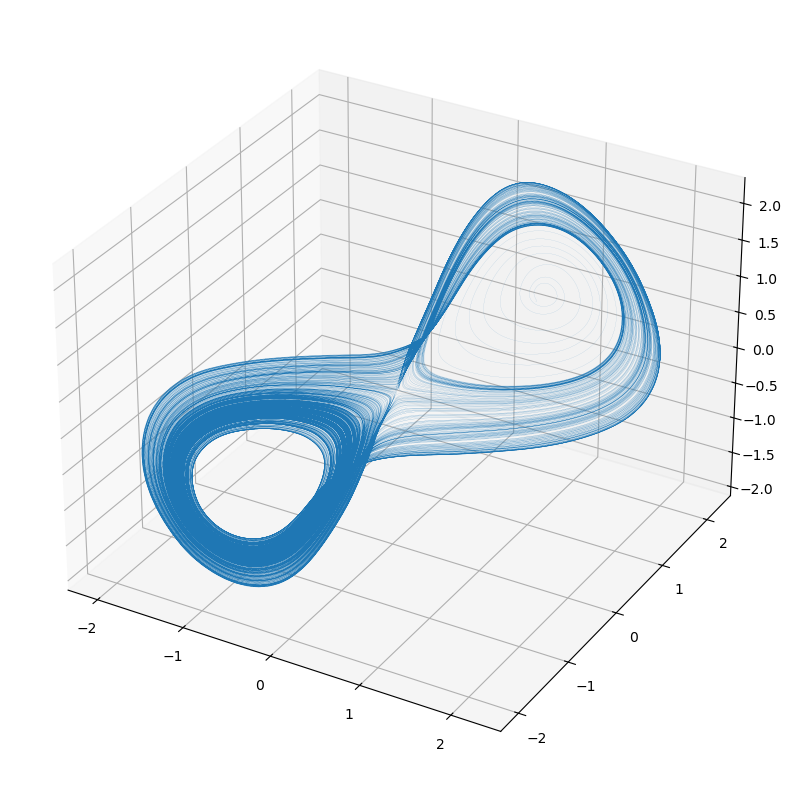

In [23]:
# plot 3D state space
x, y, z = orbit[:, 0], orbit[:, 1], orbit[:, 2]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x.numpy(), y.numpy(), z.numpy(), linewidth=0.05)
plt.show()

### 2 Maximum Lyapunov Exponent

Uncomment the following code box if you want to use the pretrained model instead of your own for this exercise.

In [ ]:
# rnn = CustomRNN(10, 50, 3)
# rnn.load_state_dict(torch.load("pretrained_model.pt"))

### 2.1
(Your answer to question Task 2.1 here)

### 2.2

In [ ]:
def naive_max_lyapunov_exponent(model, z1, T):
    """
    Compute the maximum Lyapunov exponent for a orbit starting from `z1` of length `T`.
    """
    pass  # your code here

In [ ]:
# conduct the experiment of computing the maximum Lyapunov exponent naively
...  # your code here

### 2.3

In [ ]:
@torch.no_grad()
def maximum_lyapunov_exponent(model, z1, T, T_trans=1000):
    """
    Compute the maximum Lyapunov exponent for a orbit starting from `z1` of length `T`.

    The orbit is first evolved for `T_trans` time steps to get rid of the transient.
    Uses reorthogonalization to keep Jacobian product numerically stable.
    """

    # evolve for transient time T_trans
    Z = generate_orbit(model, z1, T_trans)

    # initialize
    z = Z[-1]

    # max lyap init
    lyap = 0

    # initialize as Identity matrix
    Q = torch.eye(model.M)

    for t in range(T):
        z = model(z)
        J = torch.autograd.functional.jacobian(model, z)
        Q = J @ Q

        # reorthogonalize
        Q, R = torch.linalg.qr(Q)

        # accumulate lyapunov exponents
        lyap += torch.log(torch.abs(R[0, 0])).item()

    return lyap / T

In [ ]:
# compute the maximum Lyapunov exponent using the reorthogonalization method
...  # your code here

In [ ]:
# report the relative absolute error compared to the ground truth exponent
...  # your code here

Discuss the results here.